## Fusion Model

In [9]:
# import pandas as pd
# import numpy as np
# from sklearn.model_selection import train_test_split
# from sklearn.multioutput import MultiOutputRegressor
# from sklearn.ensemble import GradientBoostingRegressor
# from sklearn.metrics import mean_squared_error
# import joblib

# # Paths to the saved models and forecasts
# time_series_forecasts_paths = {
#     'Run_Off': '/Users/minu/Desktop/R24-066/Component 04/Backend/Save_model/arima_model_Run_Off.pkl',
#     'Open_Seam': '/Users/minu/Desktop/R24-066/Component 04/Backend/Save_model/arima_model_Open_Seam.pkl',
#     'SPI_Errors': '/Users/minu/Desktop/R24-066/Component 04/Backend/Save_model/arima_model_SPI_Errors.pkl',
#     'High_Low': '/Users/minu/Desktop/R24-066/Component 04/Backend/Save_model/arima_model_High_Low.pkl'
# }
# traditional_model_path = '/Users/minu/Desktop/R24-066/Component 04/Backend/Save_model/best_traditional_model.pkl'

# # Load the original combined data
# demographic_data = pd.read_csv('/Users/minu/Desktop/R24-066/Component 04/Dataset/demographic_data_dataset.csv')
# defect_data = pd.read_csv('/Users/minu/Desktop/R24-066/Component 04/Dataset/worker_defect_production_data.csv')

# # Convert Date columns to datetime
# demographic_data['Joining_Date'] = pd.to_datetime(demographic_data['Joining_Date'])
# defect_data['Date'] = pd.to_datetime(defect_data['Date'])

# # Combine datasets on Worker_ID
# combined_data = pd.merge(defect_data, demographic_data, on='Worker_ID')

# # Drop unnecessary columns
# fields_to_drop = ['Name', 'Joining_Date']
# combined_data.drop(columns=fields_to_drop, inplace=True)

# # Rename defect columns
# defect_columns_mapping = {
#     'Run_Off_D1': 'Run_Off',
#     'Open_Seam_D2': 'Open_Seam',
#     'SPI_Errors_D3': 'SPI_Errors',
#     'High_Low_D4': 'High_Low'
# }
# combined_data.rename(columns=defect_columns_mapping, inplace=True)

# # Load the saved time series models and traditional model
# time_series_models = {defect_type: joblib.load(path) for defect_type, path in time_series_forecasts_paths.items()}
# traditional_model = joblib.load(traditional_model_path)

# # Function to generate time series forecasts
# def generate_time_series_forecasts(models, data, defect_types):
#     forecasts = {}
#     for defect_type in defect_types:
#         model = models[defect_type]
#         forecasts[defect_type] = model.forecast(len(data))  # Adjust the forecasting logic based on your time series model implementation
#     return pd.DataFrame(forecasts, index=data.index)

# # Generate time series forecasts
# time_series_forecasts = generate_time_series_forecasts(time_series_models, combined_data, list(time_series_models.keys()))

# # Prepare the data for the fusion model
# def prepare_fusion_data(time_series_forecasts, traditional_model, combined_data, defect_types):
#     # Generate traditional model predictions
#     X_combined = combined_data.drop(columns=defect_types + ['defect_count', 'count', 'Worker_ID', 'Date'])
#     traditional_predictions = traditional_model.predict(X_combined)
    
#     # Create a DataFrame for traditional predictions
#     traditional_predictions_df = pd.DataFrame(traditional_predictions, columns=defect_types, index=combined_data.index)
    
#     # Combine traditional and time series predictions
#     combined_forecasts = time_series_forecasts.add(traditional_predictions_df, fill_value=0)
    
#     return combined_forecasts

# # Prepare the fusion data
# defect_types = ['Run_Off', 'Open_Seam', 'SPI_Errors', 'High_Low']
# combined_forecasts = prepare_fusion_data(time_series_forecasts, traditional_model, combined_data, defect_types)

# # Extract target values
# y_actual = combined_data[defect_types]

# # Align combined forecasts with y_actual
# combined_forecasts = combined_forecasts.loc[y_actual.index]

# # Train the fusion model using MultiOutputRegressor with Gradient Boosting Regressor
# X_train, X_test, y_train, y_test = train_test_split(combined_forecasts, y_actual, test_size=0.2, random_state=42)
# fusion_model = MultiOutputRegressor(GradientBoostingRegressor(random_state=42))
# fusion_model.fit(X_train, y_train)

# # Evaluate the fusion model
# y_pred = fusion_model.predict(X_test)
# mse_values = mean_squared_error(y_test, y_pred, multioutput='raw_values')
# for defect_type, mse in zip(defect_types, mse_values):
#     print(f"Fusion Model Mean Squared Error for {defect_type}: {mse}")

# # Overall MSE
# overall_mse = mean_squared_error(y_test, y_pred)
# print(f"Fusion Model Overall Mean Squared Error: {overall_mse}")

# # Save the fusion model
# fusion_model_output_path = '/Users/minu/Desktop/R24-066/Component 04/Backend/Save_model/fusion_model.pkl'
# joblib.dump(fusion_model, fusion_model_output_path)

## Fusion Model for use Stacking Model

In [10]:
# import pandas as pd
# import numpy as np
# from sklearn.model_selection import train_test_split
# from sklearn.multioutput import MultiOutputRegressor
# from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor
# from sklearn.linear_model import LinearRegression
# from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
# from sklearn.impute import SimpleImputer
# from sklearn.compose import ColumnTransformer
# from sklearn.pipeline import Pipeline
# from sklearn.preprocessing import OneHotEncoder, StandardScaler
# import joblib

# # Paths to the saved models and forecasts
# time_series_forecasts_paths = {
#     'Run_Off': '/Users/minu/Desktop/R24-066/Component 04/Backend/Save_model/arima_model_Run_Off.pkl',
#     'Open_Seam': '/Users/minu/Desktop/R24-066/Component 04/Backend/Save_model/arima_model_Open_Seam.pkl',
#     'SPI_Errors': '/Users/minu/Desktop/R24-066/Component 04/Backend/Save_model/arima_model_SPI_Errors.pkl',
#     'High_Low': '/Users/minu/Desktop/R24-066/Component 04/Backend/Save_model/arima_model_High_Low.pkl'
# }
# traditional_model_path = '/Users/minu/Desktop/R24-066/Component 04/Backend/Save_model/best_traditional_model.pkl'

# # Load the original combined data
# demographic_data = pd.read_csv('/Users/minu/Desktop/R24-066/Component 04/Dataset/demographic_data_dataset.csv')
# defect_data = pd.read_csv('/Users/minu/Desktop/R24-066/Component 04/Dataset/worker_defect_production_data.csv')

# # Convert Date columns to datetime with a specified format
# demographic_data['Joining_Date'] = pd.to_datetime(demographic_data['Joining_Date'], errors='coerce')
# defect_data['Date'] = pd.to_datetime(defect_data['Date'], errors='coerce')

# # Combine datasets on Worker_ID
# combined_data = pd.merge(defect_data, demographic_data, on='Worker_ID')

# # Drop unnecessary columns
# fields_to_drop = ['Name', 'Joining_Date']
# combined_data.drop(columns=fields_to_drop, inplace=True)

# # Rename defect columns
# defect_columns_mapping = {
#     'Run_Off_D1': 'Run_Off',
#     'Open_Seam_D2': 'Open_Seam',
#     'SPI_Errors_D3': 'SPI_Errors',
#     'High_Low_D4': 'High_Low'
# }
# combined_data.rename(columns=defect_columns_mapping, inplace=True)

# # Define categorical and numerical features
# categorical_features = ['Gender', 'Skill_Level', 'Shift']
# numerical_features = ['Age', 'Production_Volume']

# # Load the saved time series models and traditional model
# time_series_models = {defect_type: joblib.load(path) for defect_type, path in time_series_forecasts_paths.items()}
# traditional_model = joblib.load(traditional_model_path)

# # Function to generate time series forecasts
# def generate_time_series_forecasts(models, data, defect_types):
#     forecasts = {}
#     for defect_type in defect_types:
#         model = models[defect_type]
#         forecasts[defect_type] = model.forecast(len(data))  # Adjust the forecasting logic based on your time series model implementation
#     return pd.DataFrame(forecasts, index=data.index)

# # Generate time series forecasts
# time_series_forecasts = generate_time_series_forecasts(time_series_models, combined_data, list(time_series_models.keys()))

# # Prepare the data for the fusion model
# def prepare_fusion_data(time_series_forecasts, traditional_model, combined_data, defect_types):
#     # Generate traditional model predictions
#     X_combined = combined_data.drop(columns=defect_types + ['defect_count', 'count', 'Worker_ID', 'Date'])
    
#     # Ensure the same preprocessing used during traditional model training
#     preprocessor = traditional_model.named_steps['preprocessor']
#     X_combined = preprocessor.transform(X_combined)
    
#     traditional_predictions = traditional_model.named_steps['regressor'].predict(X_combined)
    
#     # Create a DataFrame for traditional predictions
#     traditional_predictions_df = pd.DataFrame(traditional_predictions, columns=defect_types, index=combined_data.index)
    
#     # Combine traditional and time series predictions
#     combined_forecasts = time_series_forecasts.add(traditional_predictions_df, fill_value=0)
    
#     return combined_forecasts

# # Prepare the fusion data
# defect_types = ['Run_Off', 'Open_Seam', 'SPI_Errors', 'High_Low']
# combined_forecasts = prepare_fusion_data(time_series_forecasts, traditional_model, combined_data, defect_types)

# # Extract target values
# y_actual = combined_data[defect_types]

# # Align combined forecasts with y_actual
# combined_forecasts = combined_forecasts.loc[y_actual.index]

# # Train the fusion model using stacking with a meta-model
# X_train, X_test, y_train, y_test = train_test_split(combined_forecasts, y_actual, test_size=0.2, random_state=42)

# # Define base models and meta-model
# base_models = [
#     ('gb', MultiOutputRegressor(GradientBoostingRegressor(random_state=42))),
#     ('rf', MultiOutputRegressor(RandomForestRegressor(random_state=42)))
# ]
# meta_model = LinearRegression()

# # Train the base models
# base_model_predictions_train = np.zeros((X_train.shape[0], len(defect_types) * len(base_models)))
# base_model_predictions_test = np.zeros((X_test.shape[0], len(defect_types) * len(base_models)))
# for i, (name, model) in enumerate(base_models):
#     model.fit(X_train, y_train)
#     base_model_predictions_train[:, i*len(defect_types):(i+1)*len(defect_types)] = model.predict(X_train)
#     base_model_predictions_test[:, i*len(defect_types):(i+1)*len(defect_types)] = model.predict(X_test)

# # Train the meta-model
# meta_model.fit(base_model_predictions_train, y_train)

# # Evaluate the stacking model
# y_pred = meta_model.predict(base_model_predictions_test)
# mse_values = mean_squared_error(y_test, y_pred, multioutput='raw_values')
# r2_values = r2_score(y_test, y_pred, multioutput='raw_values')
# mae_values = mean_absolute_error(y_test, y_pred, multioutput='raw_values')

# for defect_type, mse, r2, mae in zip(defect_types, mse_values, r2_values, mae_values):
#     print(f"Stacking Model Metrics for {defect_type}:")
#     print(f"  - Mean Squared Error: {mse}")
#     print(f"  - R² Score: {r2}")
#     print(f"  - Mean Absolute Error: {mae}")
#     print('----------------------------------------------------------------')

# # Overall evaluation metrics
# overall_mse = mean_squared_error(y_test, y_pred)
# overall_r2 = r2_score(y_test, y_pred)
# overall_mae = mean_absolute_error(y_test, y_pred)

# print(f"Stacking Model Overall Metrics:")
# print(f"  - Mean Squared Error: {overall_mse}")
# print(f"  - R² Score: {overall_r2}")
# print(f"  - Mean Absolute Error: {overall_mae}")

# # Save the stacking model
# stacking_model_output_path = '/Users/minu/Desktop/R24-066/Component 04/Backend/Save_model/stacking_model.pkl'
# joblib.dump(meta_model, stacking_model_output_path)

In [9]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.multioutput import MultiOutputRegressor
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor, StackingRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler
import joblib

# Paths to the saved models and forecasts
time_series_models = {
    'Run_Off': '/Users/minu/Desktop/R24-066/Component 04/Backend/Save_model/arima_model_Run_Off.pkl',
    'Open_Seam': '/Users/minu/Desktop/R24-066/Component 04/Backend/Save_model/arima_model_Open_Seam.pkl',
    'SPI_Errors': '/Users/minu/Desktop/R24-066/Component 04/Backend/Save_model/arima_model_SPI_Errors.pkl',
    'High_Low': '/Users/minu/Desktop/R24-066/Component 04/Backend/Save_model/arima_model_High_Low.pkl'
}
traditional_model_path = '/Users/minu/Desktop/R24-066/Component 04/Backend/Save_model/LassoRegression_best_model.pkl'

# Load the original combined data
demographic_data = pd.read_csv('/Users/minu/Desktop/R24-066/Component 04/Dataset/demographic_data_dataset.csv')
defect_data = pd.read_csv('/Users/minu/Desktop/R24-066/Component 04/Dataset/worker_defect_production_data.csv')

# Convert Date columns to datetime with a specified format
demographic_data['Joining_Date'] = pd.to_datetime(demographic_data['Joining_Date'], errors='coerce')
defect_data['Date'] = pd.to_datetime(defect_data['Date'], errors='coerce')

# Combine datasets on Worker_ID
combined_data = pd.merge(defect_data, demographic_data, on='Worker_ID')

# Drop unnecessary columns
fields_to_drop = ['Name', 'Joining_Date']
combined_data.drop(columns=fields_to_drop, inplace=True)

# Rename defect columns
defect_columns_mapping = {
    'Run_Off_D1': 'Run_Off',
    'Open_Seam_D2': 'Open_Seam',
    'SPI_Errors_D3': 'SPI_Errors',
    'High_Low_D4': 'High_Low'
}
combined_data.rename(columns=defect_columns_mapping, inplace=True)

# Add time-series features to combined_data to match traditional model's expectations
combined_data['DayOfWeek'] = combined_data['Date'].dt.dayofweek
combined_data['WeekOfYear'] = combined_data['Date'].dt.isocalendar().week
combined_data['Month'] = combined_data['Date'].dt.month
combined_data['Quarter'] = combined_data['Date'].dt.quarter

# Define categorical and numerical features
categorical_features = ['Gender', 'Skill_Level', 'Shift']
numerical_features = ['Age', 'Production_Volume']

# Load the saved time series models and traditional model
time_series_models = {defect_type: joblib.load(path) for defect_type, path in time_series_models.items()}
traditional_model = joblib.load(traditional_model_path)

# Function to generate time series forecasts
def generate_time_series_forecasts(models, data, defect_types):
    forecasts = {}
    for defect_type in defect_types:
        model = models[defect_type]
        forecasts[defect_type] = model.forecast(len(data))  # Adjust the forecasting logic based on your time series model implementation
    return pd.DataFrame(forecasts, index=data.index)

# Generate time series forecasts
time_series_forecasts = generate_time_series_forecasts(time_series_models, combined_data, list(time_series_models.keys()))

# Prepare the data for the fusion model
def prepare_fusion_data(time_series_models, traditional_model, combined_data, defect_types):
    # Generate traditional model predictions
    X_combined = combined_data.drop(columns=defect_types + ['defect_count', 'count', 'Worker_ID', 'Date'])
    
    # Ensure the same preprocessing used during traditional model training
    preprocessor = traditional_model.named_steps['preprocessor']
    X_combined = preprocessor.transform(X_combined)
    
    traditional_predictions = traditional_model.named_steps['regressor'].predict(X_combined)
    
    # Create a DataFrame for traditional predictions
    traditional_predictions_df = pd.DataFrame(traditional_predictions, columns=defect_types, index=combined_data.index)
    
    # Combine traditional and time series predictions
    combined_forecasts = time_series_models.add(traditional_predictions_df, fill_value=0)
    
    return combined_forecasts

# Prepare the fusion data
defect_types = ['Run_Off', 'Open_Seam', 'SPI_Errors', 'High_Low']
combined_forecasts = prepare_fusion_data(time_series_forecasts, traditional_model, combined_data, defect_types)

# Extract target values
y_actual = combined_data[defect_types]

# Align combined forecasts with y_actual
combined_forecasts = combined_forecasts.loc[y_actual.index]

# Train the fusion model using stacking with a meta-model
X_train, X_test, y_train, y_test = train_test_split(combined_forecasts, y_actual, test_size=0.2, random_state=42)

# Define base models and meta-model
base_models = [
    ('gb', MultiOutputRegressor(GradientBoostingRegressor(random_state=42))),
    ('rf', MultiOutputRegressor(RandomForestRegressor(random_state=42)))
]

# The meta-model should also be wrapped in MultiOutputRegressor to handle multi-output
meta_model = MultiOutputRegressor(GradientBoostingRegressor(random_state=42))

# Train the base models
base_model_predictions_train = np.zeros((X_train.shape[0], len(defect_types) * len(base_models)))
base_model_predictions_test = np.zeros((X_test.shape[0], len(defect_types) * len(base_models)))
for i, (name, model) in enumerate(base_models):
    model.fit(X_train, y_train)
    base_model_predictions_train[:, i*len(defect_types):(i+1)*len(defect_types)] = model.predict(X_train)
    base_model_predictions_test[:, i*len(defect_types):(i+1)*len(defect_types)] = model.predict(X_test)

# Combine the base model predictions with the original features
X_train_combined = np.hstack([base_model_predictions_train, X_train])
X_test_combined = np.hstack([base_model_predictions_test, X_test])

# Train the meta-model on the combined features
meta_model.fit(X_train_combined, y_train)

# Evaluate the stacking model
y_pred = meta_model.predict(X_test_combined)
mse_values = mean_squared_error(y_test, y_pred, multioutput='raw_values')
r2_values = r2_score(y_test, y_pred, multioutput='raw_values')
mae_values = mean_absolute_error(y_test, y_pred, multioutput='raw_values')

for defect_type, mse, r2, mae in zip(defect_types, mse_values, r2_values, mae_values):
    print(f"Stacking Model Metrics for {defect_type}:")
    print(f"  - Mean Squared Error: {mse}")
    print(f"  - R² Score: {r2}")
    print(f"  - Mean Absolute Error: {mae}")
    print('----------------------------------------------------------------')

# Overall evaluation metrics
overall_mse = mean_squared_error(y_test, y_pred)
overall_r2 = r2_score(y_test, y_pred)
overall_mae = mean_absolute_error(y_test, y_pred)

print(f"Stacking Model Overall Metrics:")
print(f"  - Mean Squared Error: {overall_mse}")
print(f"  - R² Score: {overall_r2}")
print(f"  - Mean Absolute Error: {overall_mae}")

# Save the stacking model
stacking_model_output_path = '/Users/minu/Desktop/R24-066/Component 04/Backend/Save_model/stacking_model.pkl'
joblib.dump(meta_model, stacking_model_output_path)
print(f"Stacking model saved to {stacking_model_output_path}")

/var/folders/68/8_7nlx1973v1qqcz0zq5wt8m0000gn/T/ipykernel_21706/3761120117.py:27: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  demographic_data['Joining_Date'] = pd.to_datetime(demographic_data['Joining_Date'], errors='coerce')
/opt/homebrew/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/opt/homebrew/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
/opt/homebrew/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is availab

Stacking Model Metrics for Run_Off:
  - Mean Squared Error: 4.187194209616314
  - R² Score: -0.011760618381762455
  - Mean Absolute Error: 1.7659593227713188
----------------------------------------------------------------
Stacking Model Metrics for Open_Seam:
  - Mean Squared Error: 4.071685528134399
  - R² Score: -0.002788102202081033
  - Mean Absolute Error: 1.7162578001874484
----------------------------------------------------------------
Stacking Model Metrics for SPI_Errors:
  - Mean Squared Error: 4.16932965324196
  - R² Score: -0.00384257423815737
  - Mean Absolute Error: 1.7746868815952985
----------------------------------------------------------------
Stacking Model Metrics for High_Low:
  - Mean Squared Error: 4.176370077427045
  - R² Score: -0.005422055480782451
  - Mean Absolute Error: 1.752037147860377
----------------------------------------------------------------
Stacking Model Overall Metrics:
  - Mean Squared Error: 4.15114486710493
  - R² Score: -0.005953337575695

In [3]:
# Evaluate base models individually
for name, model in base_models:
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    print(f"Base Model {name} - MSE: {mse}, R2: {r2}")

Base Model gb - MSE: 4.140263636774179, R2: -0.003330565616932679
Base Model rf - MSE: 4.1397409005860695, R2: -0.0032040527932994944


In [4]:
from sklearn.model_selection import RandomizedSearchCV

# Define the parameter grid for GradientBoosting
param_grid = {
    'estimator__n_estimators': [50, 100, 200],
    'estimator__max_depth': [3, 5, 7],
    'estimator__learning_rate': [0.01, 0.1, 0.2],
    'estimator__min_samples_split': [2, 5, 10],
}

# Apply RandomizedSearchCV to find the best parameters for the base model
grid_search = RandomizedSearchCV(
    MultiOutputRegressor(GradientBoostingRegressor(random_state=42)),
    param_distributions=param_grid,
    n_iter=10,  # Number of parameter settings that are sampled
    cv=5,  # 5-fold cross-validation
    verbose=2,
    random_state=42,
    n_jobs=-1
)

grid_search.fit(X_train, y_train)
best_params = grid_search.best_params_
best_model = grid_search.best_estimator_

print("Best parameters found: ", best_params)

Fitting 5 folds for each of 10 candidates, totalling 50 fits


[CV] END estimator__learning_rate=0.1, estimator__max_depth=3, estimator__min_samples_split=5, estimator__n_estimators=50; total time=   0.0s
[CV] END estimator__learning_rate=0.1, estimator__max_depth=3, estimator__min_samples_split=5, estimator__n_estimators=50; total time=   0.1s
[CV] END estimator__learning_rate=0.1, estimator__max_depth=3, estimator__min_samples_split=5, estimator__n_estimators=50; total time=   0.1s
[CV] END estimator__learning_rate=0.1, estimator__max_depth=3, estimator__min_samples_split=5, estimator__n_estimators=50; total time=   0.1s
[CV] END estimator__learning_rate=0.01, estimator__max_depth=3, estimator__min_samples_split=2, estimator__n_estimators=50; total time=   0.1s
[CV] END estimator__learning_rate=0.1, estimator__max_depth=3, estimator__min_samples_split=5, estimator__n_estimators=50; total time=   0.1s
[CV] END estimator__learning_rate=0.01, estimator__max_depth=3, estimator__min_samples_split=2, estimator__n_estimators=50; total time=   0.1s
[CV]

In [6]:
print(f"Stacking Model Overall Metrics:")
print(f"  - Mean Squared Error: {overall_mse}")
print(f"  - R² Score: {overall_r2}")
print(f"  - Mean Absolute Error: {overall_mae}")

Stacking Model Overall Metrics:
  - Mean Squared Error: 4.140263636774179
  - R² Score: -0.003330565616932679
  - Mean Absolute Error: 1.7466020943976357


In [16]:
from sklearn.model_selection import cross_val_score

# Perform cross-validation on the fusion model
cv_scores = cross_val_score(meta_model, X_train_combined, y_train, cv=5, scoring='neg_mean_squared_error')
print(f"Cross-Validation Scores (MSE): {-cv_scores}")
print(f"Mean CV MSE: {-cv_scores.mean()}")

Cross-Validation Scores (MSE): [3.99731449 4.03467744 3.88140285 4.04714184 4.10964671]
Mean CV MSE: 4.014036666248644


In [22]:
print("Columns in X_train:", X_train.columns)
print("Columns expected by the preprocessor:", traditional_model.named_steps['preprocessor'].transformers_)

Columns in X_train: Index(['Run_Off', 'Open_Seam', 'SPI_Errors', 'High_Low'], dtype='object')
Columns expected by the preprocessor: [('onehot', OneHotEncoder(), ['Gender', 'Skill_Level', 'Shift']), ('num', StandardScaler(), ['Age', 'Production_Volume', 'DayOfWeek', 'WeekOfYear', 'Month', 'Quarter']), ('remainder', 'drop', [5])]


In [26]:
# Drop the target columns (defect types) from X (the features dataset)
X = combined_data.drop(columns=defect_types + ['defect_count', 'count', 'Worker_ID', 'Date'])

# Define y as the defect columns (target labels)
y = combined_data[defect_types]

# Split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [27]:
# Preprocess the training data
X_train_preprocessed = traditional_model.named_steps['preprocessor'].transform(X_train)

# Preprocess the test data
X_test_preprocessed = traditional_model.named_steps['preprocessor'].transform(X_test)

# Train the base models on preprocessed data
base_model_1 = base_models[0][1].fit(X_train_preprocessed, y_train)
base_model_2 = base_models[1][1].fit(X_train_preprocessed, y_train)

# Make predictions using the base models
y_pred_base_1 = base_model_1.predict(X_test_preprocessed)
y_pred_base_2 = base_model_2.predict(X_test_preprocessed)

# Evaluate the predictions
mse_base_1 = mean_squared_error(y_test, y_pred_base_1)
mse_base_2 = mean_squared_error(y_test, y_pred_base_2)

print(f"Base Model 1 MSE: {mse_base_1}")
print(f"Base Model 2 MSE: {mse_base_2}")

Base Model 1 MSE: 4.437351641318419
Base Model 2 MSE: 5.239089664798295


In [28]:
from sklearn.model_selection import GridSearchCV

# Example tuning for GradientBoosting meta-model
param_grid = {
    'estimator__n_estimators': [50, 100, 200],
    'estimator__learning_rate': [0.01, 0.1, 0.2],
    'estimator__max_depth': [3, 5, 7],
}

# GridSearch for tuning
grid_search = GridSearchCV(MultiOutputRegressor(GradientBoostingRegressor(random_state=42)),
                           param_grid, cv=5, scoring='neg_mean_squared_error', n_jobs=-1)
grid_search.fit(X_train_combined, y_train)

# Best parameters and performance
print(f"Best Params: {grid_search.best_params_}")
print(f"Best CV Score: {-grid_search.best_score_}")

Best Params: {'estimator__learning_rate': 0.01, 'estimator__max_depth': 3, 'estimator__n_estimators': 50}
Best CV Score: 4.014036666248644


In [60]:
from sklearn.inspection import permutation_importance

# Assuming `X_test_preprocessed` and `y_test_single` are properly defined and aligned

try:
    # Apply permutation importance
    result = permutation_importance(base_estimator, X_test_preprocessed, y_test_single, n_repeats=10, random_state=42)
    importances = result.importances_mean
    print("Permutation Importances:", importances)

    # Plotting the feature importances
    plt.figure(figsize=(10, 6))
    plt.bar(range(len(importances)), importances, align='center')
    plt.xticks(range(len(importances)), X_test_preprocessed.columns, rotation=90)
    plt.title('Permutation Feature Importances')
    plt.xlabel('Features')
    plt.ylabel('Importance')
    plt.show()

except ValueError as e:
    print(f"Error during permutation importance calculation: {e}")

Error during permutation importance calculation: The feature names should match those that were passed during fit.
Feature names unseen at fit time:
- num__Age
- num__DayOfWeek
- num__Month
- num__Production_Volume
- num__Quarter
- ...
Feature names seen at fit time, yet now missing:
- High_Low
- Open_Seam
- Run_Off
- SPI_Errors



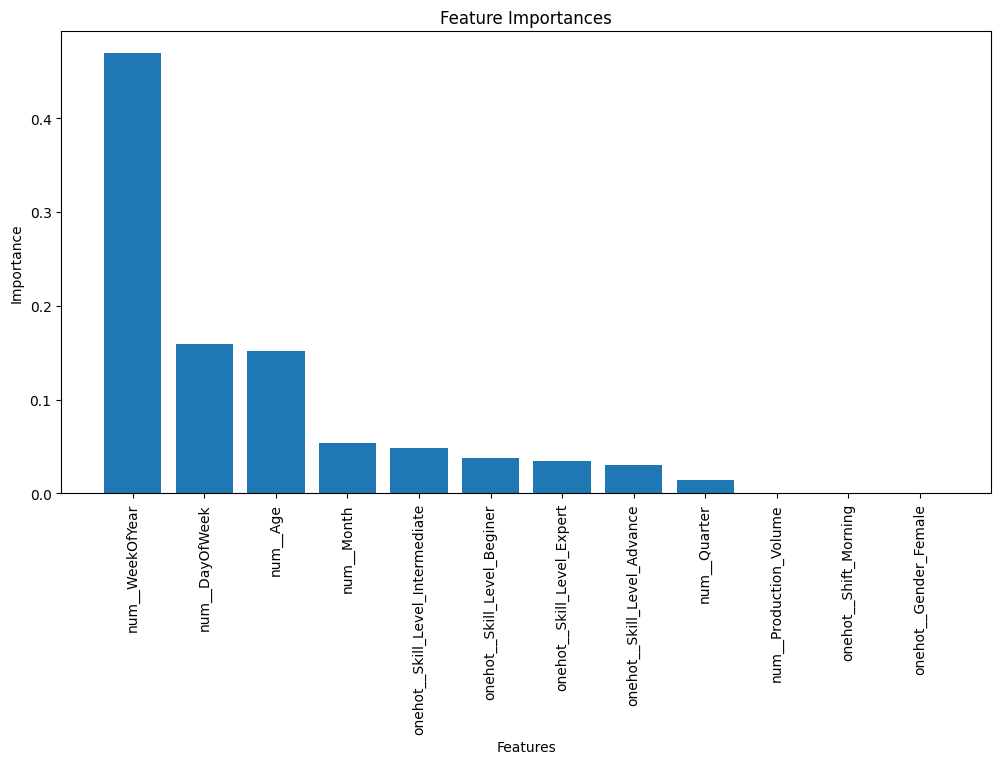

In [66]:
import matplotlib.pyplot as plt
import numpy as np

# Assuming importances and indices are correctly calculated from the model
importances = model_pipeline.named_steps['regressor'].estimators_[0].feature_importances_
indices = np.argsort(importances)[::-1]

# The preprocessor has one-hot encoded features, let's extract feature names
feature_names = preprocessor.get_feature_names_out()

# Plotting feature importances correctly
plt.figure(figsize=(12, 6))
plt.title("Feature Importances")
plt.bar(range(len(importances)), importances[indices], align='center')
plt.xticks(range(len(importances)), feature_names[indices], rotation=90)
plt.xlim([-1, len(importances)])
plt.xlabel("Features")
plt.ylabel("Importance")
plt.show()

In [ ]:
from sklearn.model_selection import cross_val_score

# Perform cross-validation on the fusion model
cv_scores = cross_val_score(meta_model, X_train_combined, y_train, cv=5, scoring='neg_mean_squared_error')
print(f"Cross-Validation Scores (MSE): {-cv_scores}")
print(f"Mean CV MSE: {-cv_scores.mean()}")

Cross-Validation Scores (MSE): [3.99731449 4.03467744 3.88140285 4.04714184 4.10964671]
Mean CV MSE: 4.014036666248644


In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.multioutput import MultiOutputRegressor
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
import joblib
import os

# Define file paths
time_series_models = {
    'Run_Off': '/Users/minu/Desktop/R24-066/Component 04/Backend/Save_model/arima_model_Run_Off.pkl',
    'Open_Seam': '/Users/minu/Desktop/R24-066/Component 04/Backend/Save_model/arima_model_Open_Seam.pkl',
    'SPI_Errors': '/Users/minu/Desktop/R24-066/Component 04/Backend/Save_model/arima_model_SPI_Errors.pkl',
    'High_Low': '/Users/minu/Desktop/R24-066/Component 04/Backend/Save_model/arima_model_High_Low.pkl'
}
traditional_model_path = '/Users/minu/Desktop/R24-066/Component 04/Backend/Save_model/LassoRegression_best_model.pkl'
demographic_data_path = '/Users/minu/Desktop/R24-066/Component 04/Dataset/demographic_data_dataset.csv'
defect_data_path = '/Users/minu/Desktop/R24-066/Component 04/Dataset/worker_defect_production_data.csv'

# Load data
demographic_data = pd.read_csv(demographic_data_path)
defect_data = pd.read_csv(defect_data_path)

# Convert Date columns to datetime
demographic_data['Joining_Date'] = pd.to_datetime(demographic_data['Joining_Date'], errors='coerce')
defect_data['Date'] = pd.to_datetime(defect_data['Date'], errors='coerce')

# Merge datasets
combined_data = pd.merge(defect_data, demographic_data, on='Worker_ID')

# Drop unnecessary columns and add time-series features
combined_data.drop(columns=['Name', 'Joining_Date'], inplace=True)
combined_data['DayOfWeek'] = combined_data['Date'].dt.dayofweek
combined_data['WeekOfYear'] = combined_data['Date'].dt.isocalendar().week
combined_data['Month'] = combined_data['Date'].dt.month
combined_data['Quarter'] = combined_data['Date'].dt.quarter

# Load saved models
time_series_models = {defect_type: joblib.load(path) for defect_type, path in time_series_models.items()}
traditional_model = joblib.load(traditional_model_path)

# Generate time series forecasts
def generate_time_series_forecasts(models, data, defect_types):
    forecasts = {}
    for defect_type in defect_types:
        model = models[defect_type]
        forecasts[defect_type] = model.forecast(len(data))  # Modify this logic based on your model
    return pd.DataFrame(forecasts, index=data.index)

# Generate forecasts and prepare fusion data
time_series_forecasts = generate_time_series_forecasts(time_series_models, combined_data, list(time_series_models.keys()))

def prepare_fusion_data(time_series_forecasts, traditional_model, combined_data, defect_types):
    X_combined = combined_data.drop(columns=defect_types + ['defect_count', 'count', 'Worker_ID', 'Date'])
    preprocessor = traditional_model.named_steps['preprocessor']
    X_combined = preprocessor.transform(X_combined)
    traditional_predictions = traditional_model.named_steps['regressor'].predict(X_combined)
    traditional_predictions_df = pd.DataFrame(traditional_predictions, columns=defect_types, index=combined_data.index)
    combined_forecasts = time_series_forecasts.add(traditional_predictions_df, fill_value=0)
    return combined_forecasts

combined_forecasts = prepare_fusion_data(time_series_forecasts, traditional_model, combined_data, list(time_series_models.keys()))

# Align and evaluate model
y_actual = combined_data[list(time_series_models.keys())]
combined_forecasts = combined_forecasts.loc[y_actual.index]

# Train and evaluate fusion model
X_train, X_test, y_train, y_test = train_test_split(combined_forecasts, y_actual, test_size=0.2, random_state=42)
base_models = [
    ('gb', MultiOutputRegressor(GradientBoostingRegressor(random_state=42))),
    ('rf', MultiOutputRegressor(RandomForestRegressor(random_state=42)))
]
meta_model = MultiOutputRegressor(GradientBoostingRegressor(random_state=42))
base_model_predictions_train = np.zeros((X_train.shape[0], len(time_series_models) * len(base_models)))
base_model_predictions_test = np.zeros((X_test.shape[0], len(time_series_models) * len(base_models)))

for i, (name, model) in enumerate(base_models):
    model.fit(X_train, y_train)
    base_model_predictions_train[:, i*len(time_series_models):(i+1)*len(time_series_models)] = model.predict(X_train)
    base_model_predictions_test[:, i*len(time_series_models):(i+1)*len(time_series_models)] = model.predict(X_test)

X_train_combined = np.hstack([base_model_predictions_train, X_train])
X_test_combined = np.hstack([base_model_predictions_test, X_test])
meta_model.fit(X_train_combined, y_train)

# Evaluate and save model
y_pred = meta_model.predict(X_test_combined)
mse_values = mean_squared_error(y_test, y_pred, multioutput='raw_values')
r2_values = r2_score(y_test, y_pred, multioutput='raw_values')
mae_values = mean_absolute_error(y_test, y_pred, multioutput='raw_values')

for defect_type, mse, r2, mae in zip(time_series_models.keys(), mse_values, r2_values, mae_values):
    print(f"Stacking Model Metrics for {defect_type}:")
    print(f"  - Mean Squared Error: {mse}")
    print(f"  - R² Score: {r2}")
    print(f"  - Mean Absolute Error: {mae}")
    print('----------------------------------------------------------------')

# Overall evaluation metrics
overall_mse = mean_squared_error(y_test, y_pred)
overall_r2 = r2_score(y_test, y_pred)
overall_mae = mean_absolute_error(y_test, y_pred)

print(f"Stacking Model Overall Metrics:")
print(f"  - Mean Squared Error: {overall_mse}")
print(f"  - R² Score: {overall_r2}")
print(f"  - Mean Absolute Error: {overall_mae}")

# Save the stacking model
stacking_model_output_path = '/Users/minu/Desktop/R24-066/Component 04/Backend/Save_model/stacking_new_model.pkl'
joblib.dump(meta_model, stacking_model_output_path)
print(f"Stacking model saved to {stacking_model_output_path}")


/var/folders/68/8_7nlx1973v1qqcz0zq5wt8m0000gn/T/ipykernel_14643/826638949.py:27: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  demographic_data['Joining_Date'] = pd.to_datetime(demographic_data['Joining_Date'], errors='coerce')
/opt/homebrew/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/opt/homebrew/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
/opt/homebrew/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is availabl

Stacking Model Metrics for Run_Off:
  - Mean Squared Error: 4.187194209616314
  - R² Score: -0.011760618381762455
  - Mean Absolute Error: 1.7659593227713188
----------------------------------------------------------------
Stacking Model Metrics for Open_Seam:
  - Mean Squared Error: 4.071685528134399
  - R² Score: -0.002788102202081033
  - Mean Absolute Error: 1.7162578001874484
----------------------------------------------------------------
Stacking Model Metrics for SPI_Errors:
  - Mean Squared Error: 4.16932965324196
  - R² Score: -0.00384257423815737
  - Mean Absolute Error: 1.7746868815952985
----------------------------------------------------------------
Stacking Model Metrics for High_Low:
  - Mean Squared Error: 4.176370077427045
  - R² Score: -0.005422055480782451
  - Mean Absolute Error: 1.752037147860377
----------------------------------------------------------------
Stacking Model Overall Metrics:
  - Mean Squared Error: 4.15114486710493
  - R² Score: -0.005953337575695

In [9]:
#Convert feedback to DataFrame after training and evaluating the stacking model
worker_feedback = []

# Iterate over each unique worker to generate predictions and evaluate
for worker_id in combined_data['Worker_ID'].unique():
    # Extract data for each worker
    worker_data = combined_data[combined_data['Worker_ID'] == worker_id]

    if worker_data.empty:
        continue

    # Generate time-series forecasts for the worker
    worker_time_series_forecasts = generate_time_series_forecasts(
        time_series_models, worker_data, list(time_series_models.keys())
    )

    # Prepare fusion data for the worker
    worker_combined_forecasts = prepare_fusion_data(
        worker_time_series_forecasts, traditional_model, worker_data, list(time_series_models.keys())
    )

    # Align actual values for the worker
    y_actual_worker = worker_data[list(time_series_models.keys())]
    worker_combined_forecasts = worker_combined_forecasts.loc[y_actual_worker.index]

    # Generate base model predictions for the worker
    base_model_predictions_worker = np.zeros((worker_combined_forecasts.shape[0], len(time_series_models) * len(base_models)))

    for i, (name, model) in enumerate(base_models):
        base_model_predictions_worker[:, i*len(time_series_models):(i+1)*len(time_series_models)] = model.predict(worker_combined_forecasts)

    # Combine base model predictions with original features for stacking model
    X_worker_combined = np.hstack([base_model_predictions_worker, worker_combined_forecasts])

    # Predict using the stacking model (meta-model)
    y_pred_worker = meta_model.predict(X_worker_combined)

    # Calculate evaluation metrics
    mse_worker = mean_squared_error(y_actual_worker, y_pred_worker, multioutput='raw_values')
    r2_worker = r2_score(y_actual_worker, y_pred_worker, multioutput='raw_values')
    mae_worker = mean_absolute_error(y_actual_worker, y_pred_worker, multioutput='raw_values')

    # Store feedback for the worker
    feedback = {
        'Worker_ID': worker_id,
        'Mean Squared Error': mse_worker.tolist(),
        'R² Score': r2_worker.tolist(),
        'Mean Absolute Error': mae_worker.tolist()
    }
    worker_feedback.append(feedback)

# Convert feedback to DataFrame for further analysis
worker_feedback_df = pd.DataFrame(worker_feedback)

# Function to identify high and low defect types
def analyze_worker_defect_types(worker_id, feedback_df, defect_types):
    # Retrieve feedback for the specified worker
    worker_feedback = feedback_df[feedback_df['Worker_ID'] == worker_id]

    # If the worker is found
    if not worker_feedback.empty:
        print(f"Feedback for Worker ID: {worker_id}")

        # Extract metrics
        mse_list = worker_feedback['Mean Squared Error'].values[0]
        r2_list = worker_feedback['R² Score'].values[0]
        mae_list = worker_feedback['Mean Absolute Error'].values[0]

        # Determine the highest and lowest defect types
        highest_defect_type_index = np.argmax(mse_list)  # Index of the defect type with the highest MSE
        lowest_defect_type_index = np.argmin(mse_list)   # Index of the defect type with the lowest MSE

        highest_defect_type = defect_types[highest_defect_type_index]
        lowest_defect_type = defect_types[lowest_defect_type_index]

        # Provide feedback message
        print(f"Defect type with the highest error: {highest_defect_type} (MSE: {mse_list[highest_defect_type_index]:.4f}, R²: {r2_list[highest_defect_type_index]:.2f}, MAE: {mae_list[highest_defect_type_index]:.4f})")
        print(f"Defect type with the lowest error: {lowest_defect_type} (MSE: {mse_list[lowest_defect_type_index]:.4f}, R²: {r2_list[lowest_defect_type_index]:.2f}, MAE: {mae_list[lowest_defect_type_index]:.4f})")

        # Message for the highest defect type
        print(f"Attention needed: Please focus on improving {highest_defect_type} as it has the highest error metrics.")
    else:
        print(f"No feedback found for Worker ID: {worker_id}")

# Example Usage
worker_id_to_search = input("Enter the Worker ID to search for feedback: ")
defect_types = ['Run_Off', 'Open_Seam', 'SPI_Errors', 'High_Low']  # List of defect types
analyze_worker_defect_types(worker_id_to_search, worker_feedback_df, defect_types)

/opt/homebrew/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/opt/homebrew/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
/opt/homebrew/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/opt/homebrew/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/opt/homebrew/lib/pyt

Feedback for Worker ID: W_00001
Defect type with the highest error: Run_Off (MSE: 4.5991, R²: -0.00, MAE: 1.8632)
Defect type with the lowest error: SPI_Errors (MSE: 3.4820, R²: -0.00, MAE: 1.6368)
Attention needed: Please focus on improving Run_Off as it has the highest error metrics.
